In [2]:
# Common imports
import numpy as np
import os


In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

import warnings
warnings.filterwarnings('ignore')

In [4]:
##########  Using gym
import gym

In [5]:
##########  Example Cart_Pole

# It is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. 
# The agent must move the cart left or right to keep the pole upright.

# selecting the gym environment
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [6]:
# Initialization of the environment with reset
#env.seed(42)
obs = env.reset()

In [7]:
#In this example we will set mode="rgb_array" to get an image of the environment as a NumPy array:
img = env.render()
img.shape

(400, 600, 3)

In [8]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

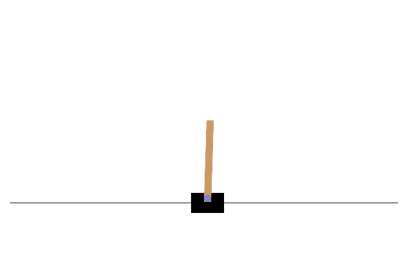

In [9]:
plot_environment(env)
plt.show()

In [10]:
#####################   USING A NEURAL NETWORK 

In [11]:
# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
#########################  POLICY GRADIENTS  ###########################

In [13]:
# To train this neural network we will need to define the target probabilities y. If an action is good we should increase 
# its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? 
# The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear 
# which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? 
# This is called the credit assignment problem.

# The Policy Gradients algorithm tackles this problem by first playing multiple episodes, then making the actions 
# in good episodes slightly more likely, while actions in bad episodes are made slightly less likely. 
# First we play, then we go back and think about what we did.

# Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever 
# action it takes is the right one, so we can compute the loss and its gradients 
# (we will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be):

def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        #print("obs", obs)
        #left_proba = model(obs[0])              # output of the model after obs is used as input
        #left_proba = model(obs[0].reshape(-1, 1,4))              # output of the model after obs is used as input
        left_proba = model(obs.reshape(-1, 1,4))              # output of the model after obs is used as input
        #print("left_proba", left_proba)
        action = (tf.random.uniform([1, 1]) > left_proba)  # Action True or False
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, tr,info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

# If left_proba is high, then action will most likely be False (since a random number uniformally sampled between 0 and 1 
# will probably not be greater than left_proba). And False means 0 when you cast it to a number, so y_target would be equal 
# to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 
# 100% (so we took the right action).

In [14]:
# Now let's create another function that will rely on the play_one_step() function to play multiple episodes,
# returning all the rewards and gradients, for each episode and each step:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        obs=obs[0]
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [15]:
# The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and 
# looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will 
# compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [16]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [17]:
# Example of use discounts
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22, -40, -50])

In [18]:
# Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor 
# of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 
# (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), 
# which leads to a discounted reward of -22:

In [19]:
# To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted 
# rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [20]:
# Example of use

# We will run 150 training iterations, playing 10 episodes per iteration, and each episode
# will last at most 200 steps. We will use a discount factor of 0.95:

n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [21]:
# We also need an optimizer and the loss function. A regular Adam optimizer with
# learning rate 0.01, and we will use the binary cross-entropy loss function
# because we are training a binary classifier (there are two possible actions: left or right):

optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [22]:
# NN model 

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=(1,4)),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [23]:
env = gym.make("CartPole-v1")
#env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     
    print("\rIteration: {}, mean rewards: {:.1f}".format(          
        iteration, total_rewards / n_episodes_per_update), end="") 
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()


Iteration: 149, mean rewards: 188.1

• At each training iteration, this loop calls the play_multiple_episodes() function,
which plays the game 10 times and returns all the rewards and gradients for
every episode and step.
• Then we call the discount_and_normalize_rewards() to compute each action’s
normalized advantage (which in the code we call the final_reward). This provides
a measure of how good or bad each action actually was, in hindsight.
• Next, we go through each trainable variable, and for each of them we compute
the weighted mean of the gradients for that variable over all episodes and all
steps, weighted by the final_reward.
• Finally, we apply these mean gradients using the optimizer: the model’s trainable
variables will be tweaked.

In [24]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="human")
    #env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    obs = obs[0]
    for step in range(n_max_steps):
        frames.append(env.render())
        left_proba = model.predict(obs.reshape(-1, 1,4))
        #left_proba = model(obs.reshape(-1, 1,4)) 
        action = int(np.random.rand() > left_proba)
        obs, reward, done, tr, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [25]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

TypeError: Image data of dtype object cannot be converted to float

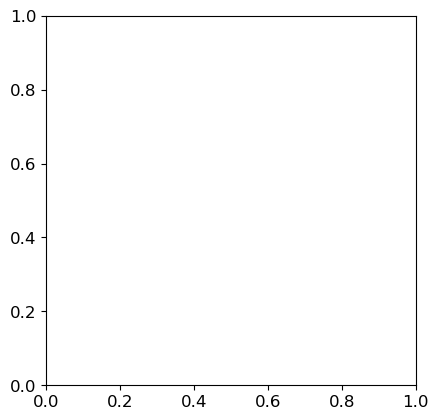

In [26]:
frames = render_policy_net(model)
plot_animation(frames)